# <font color='blue'>Dog Detector</font>

Problema de Negócio:

Construir um modelo de Inteligência Artificial capaz de classificar imagens considerando 3 categorias, sendo os meus cachorros. Dada uma nova imagem de uma dessas categorias o modelo deve ser capaz de classificar e indicar o que é a imagem.

In [1]:
# Silencia mensagens do TF
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import PIL
from PIL import Image
#PreTrained Model
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, layers, models
from keras.layers import *
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

## Carregando os Dados do disco

In [19]:
# Substitua pelo caminho local do seu arquivo ZIP
data_dir = "C:/Users/rafae/OneDrive/Documents/DeepLearning/MyDogs Detector/data/dogs"

data_dir = pathlib.Path(data_dir)

In [21]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

195


### Parâmetros

In [24]:
batch_size = 64
img_height = 224
img_width = 224

### Criaçao do dataset de treino

In [27]:
treino_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 195 files belonging to 3 classes.
Using 137 files for training.


### Criação do dataset de Teste

In [30]:
teste_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 195 files belonging to 3 classes.
Using 58 files for validation.


In [32]:
nomes_classes = ['kiara','rex','rocky']
print(nomes_classes)

['kiara', 'rex', 'rocky']


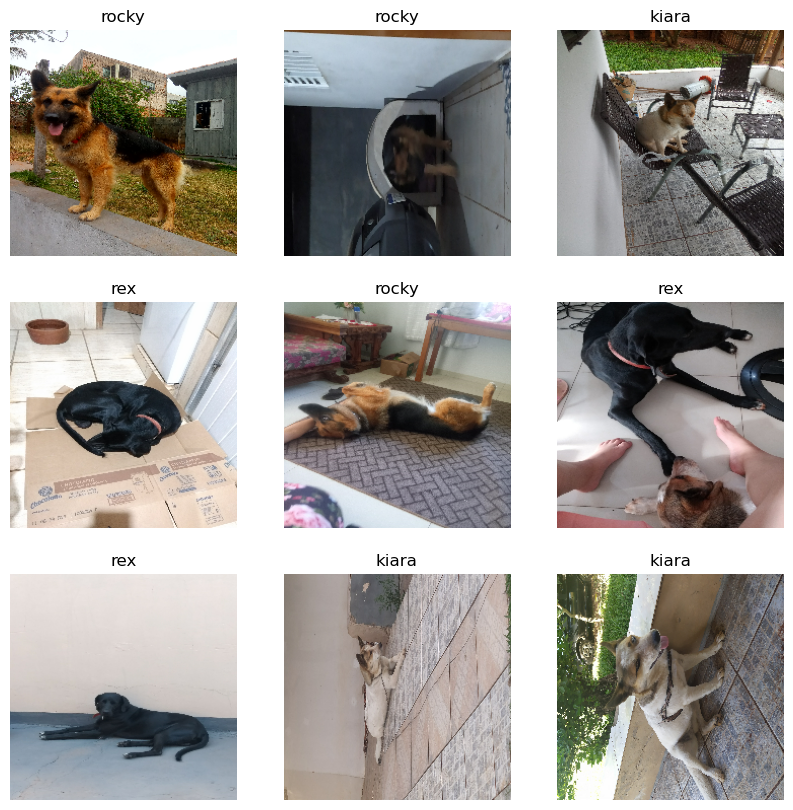

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in treino_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(nomes_classes[labels[i]])
    plt.axis("off")

In [35]:
imagens_treino = []
labels_treino = []

for images, labels in treino_ds.take(1):
    imagens_treino.append(images.numpy().astype("uint8"))
    labels_treino.append(labels.numpy().astype("int"))

In [36]:
labels_treino = labels_treino[0]

In [40]:
imagens_treino = imagens_treino[0]

In [42]:
print(labels_treino)
print(imagens_treino)

[2 2 0 1 1 0 0 2 2 0 1 1 0 1 2 0 1 0 2 0 1 2 2 0 2 2 2 2 0 1 2 0 1 0 1 0 1
 2 0 0 0 1 0 2 1 2 1 1 2 2 2 2 0 2 0 0 0 2 1 0 0 1 1 1]
[[[[150 160 161]
   [152 161 160]
   [147 157 158]
   ...
   [ 30  34  37]
   [ 25  30  33]
   [ 34  38  41]]

  [[146 156 158]
   [151 161 162]
   [149 159 160]
   ...
   [ 29  30  34]
   [ 30  31  33]
   [ 32  32  34]]

  [[145 156 158]
   [150 160 162]
   [151 159 162]
   ...
   [ 26  30  33]
   [ 29  31  30]
   [ 30  31  33]]

  ...

  [[ 54  41  33]
   [ 53  40  31]
   [ 53  40  32]
   ...
   [  0   1   0]
   [  0   1   0]
   [  0   1   0]]

  [[ 51  38  32]
   [ 50  37  29]
   [ 51  38  30]
   ...
   [  0   1   0]
   [  0   1   0]
   [  0   1   0]]

  [[ 43  33  24]
   [ 49  39  30]
   [ 52  38  29]
   ...
   [  0   1   0]
   [  0   1   0]
   [  0   1   0]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [145 138 130]
   [147 140 132]
   [148 139 134]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [148 141 133]
   [146 

In [44]:
imagens_teste = []
labels_teste = []

for images, labels in teste_ds.take(1):
    imagens_teste.append(images.numpy().astype("uint8"))
    labels_teste.append(labels.numpy().astype("uint8"))

In [45]:
imagens_teste = imagens_teste[0]
labels_teste = labels_teste[0]

## Pré-Processamento e Visualização das Imagens

In [49]:
# Normaliza os valores dos pixels para que os dados fiquem na mesma escala
imagens_treino = imagens_treino / 255.0
imagens_teste = imagens_teste / 255.0

In [51]:
# Função para exibir as imagens
def visualiza_imagens(images, labels):
    plt.figure(figsize = (10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap = plt.cm.binary)
        plt.xlabel(nomes_classes[labels[i]])
    plt.show()

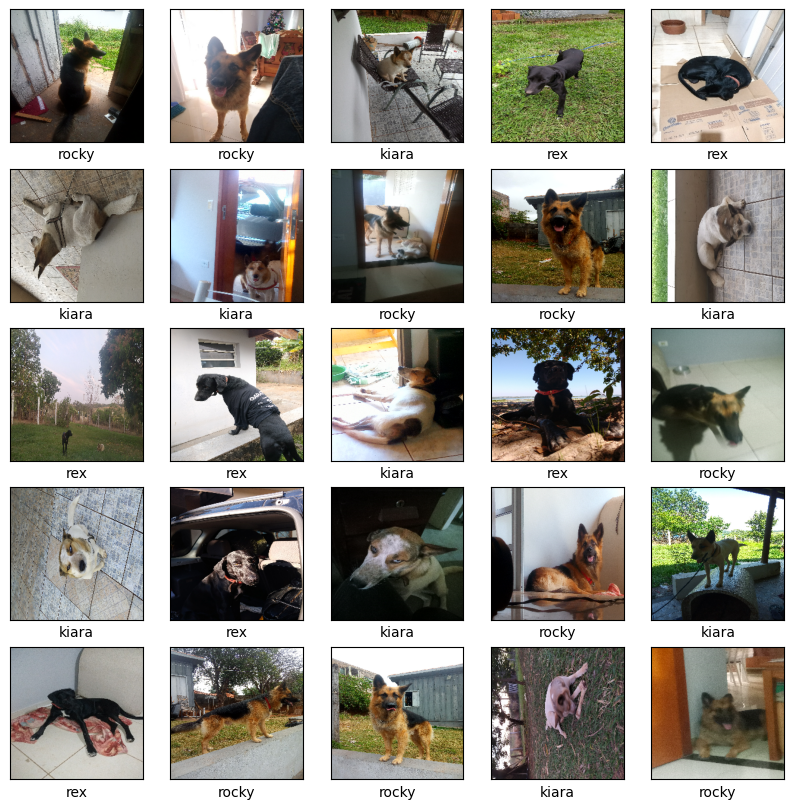

In [53]:
# Executa a função
visualiza_imagens(imagens_treino, labels_treino)

## Construção do Modelo

In [56]:
def M_B(M_name,Base ,EPO, Drop_Val,A_Func,NUM_CLASS,imagens_treino,labels_treino):
    # Define the name for your model
    model_name = M_name
    # Build the model
    model = models.Sequential(name=model_name)

    # Add the pre-trained DenseNet121_base 
    model.add(Base)

    # Batch Normalization
    model.add(BatchNormalization())

    # Dropout 
    model.add(Dropout(Drop_Val))

    # Add a dense layer with 220 units and ReLU activation function
    model.add(Dense(50, activation='relu'))

    # Add the output layer with 10 units and Softmax activation function
    model.add(Dense(NUM_CLASS, activation=A_Func))

    # Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Build the model
    model.build((None, img_height, img_width, 3))

    # Print model summary
    print(model.summary())
    
    #Early_Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    #Fitting Model
    history = model.fit(imagens_treino, labels_treino,
                            epochs= EPO,
                            validation_data = (imagens_teste, labels_teste),
                            callbacks = early_stopping)
    
    return history, model

In [58]:
# # Define the URL of the model
# url = "https://tfhub.dev/google/bit/m-r50x1/1"

# # Load the model from the URL
# model_E = hub.KerasLayer(url)

# # Set the model to be non-trainable
# model_E.trainable = False

# Load the pre-trained DenseNet121 model without the top classification layer
DenseNet121_base = DenseNet121(weights='imagenet',
                                    include_top=False, 
                                   input_shape=(img_height, img_width,3),
                                     pooling = 'avg'
                                   )

# Freeze the pre-trained base model layers
DenseNet121_base.trainable = False

In [62]:
# Train Model
history , model = M_B("Gepetao_Model",
              DenseNet121_base,
              50,
              0.25,
              'softmax',
              3,
            imagens_treino,labels_treino)

Model: "Gepetao_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                51250     
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 7,093,003
Trainable params: 53,451
Non-trainable params: 7,039,552
______________________________________

In [64]:
# Avalia o modelo
erro_teste, acc_teste = model.evaluate(imagens_teste, labels_teste, verbose = 2)

2/2 - 2s - loss: 0.2755 - accuracy: 0.8966 - 2s/epoch - 1s/step


In [66]:
print('\nAcurácia com Dados de Teste:', acc_teste)


Acurácia com Dados de Teste: 0.8965517282485962


## Deploy do Modelo

A largura da imagem é:  4000
A altura da imagem é:  2250


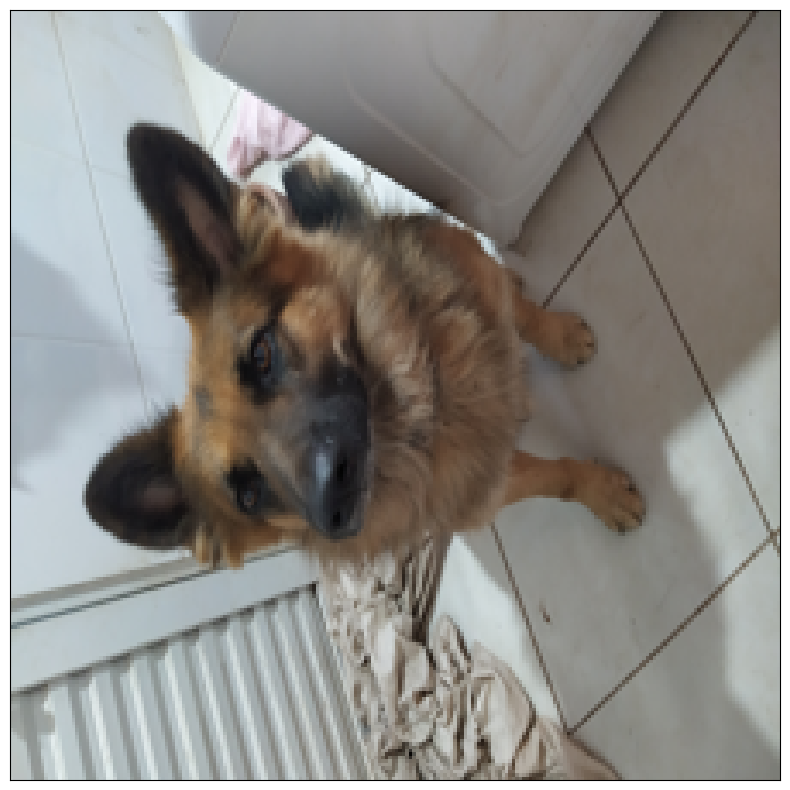

In [116]:
# Carrega uma nova imagem
nova_imagem = Image.open("data/previsao/img1.jpg")

# Dimensões da imagem (em pixels)
nova_imagem.size

# Obtém largura e altura da imagem
largura = nova_imagem.width
altura = nova_imagem.height

print("A largura da imagem é: ", largura)
print("A altura da imagem é: ", altura)

# Redimensiona para 224 x 224 pixels
nova_imagem = nova_imagem.resize((img_height, img_width))

# Exibir a imagem
plt.figure(figsize = (10,10))
plt.imshow(nova_imagem)
plt.xticks([])
plt.yticks([])
plt.show()

# Converte a imagem para um array NumPy e normaliza
nova_imagem_array = np.array(nova_imagem) / 255.0

# Expande a dimensão do array para que ele tenha o formato (1, 32, 32, 3)
nova_imagem_array = np.expand_dims(nova_imagem_array, axis = 0) 

In [118]:
# Previsões
previsoes = model.predict(nova_imagem_array)
print(previsoes)

# Obtém a classe com maior probabilidade e o nome da classe
classe_prevista = np.argmax(previsoes)
nome_classe_prevista = nomes_classes[classe_prevista]

print("A nova imagem foi classificada como:", nome_classe_prevista.upper())

1/1 [==============================] - 0s 86ms/step
[[2.4371839e-03 1.6634857e-04 9.9739647e-01]]
A nova imagem foi classificada como: ROCKY


# Fim